# Defining marker-associated cell types

Here we will use dual-omics SHARE-seq dataset, more specicially the dataset from figure4 in [SHARE-seq study](https://www.sciencedirect.com/science/article/abs/pii/S0092867420312538), "multiome_ma2020_fig4" as an example to illustrate how SIMBA defines novel cell type based on identified markers.


In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import simba as si
si.__version__

'1.2'

In [3]:
workdir = 'result_multiome_shareseq_grn'
si.settings.set_workdir(workdir)

Saving results in: result_multiome_shareseq_grn


In [4]:
si.settings.set_figure_params(dpi=80,
                              style='white',
                              fig_size=[4,4],
                              rc={'image.cmap': 'viridis', 'font.size':'22'})


In [5]:
# to make plots prettier
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/tmp/ipykernel_15227/3381039072.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


### Identify master regulators

In [6]:
prefix=workdir
adata_C = si.read_h5ad(os.path.join(prefix,'adata_C.h5ad'))
adata_G = si.read_h5ad(os.path.join(prefix,'adata_G.h5ad'))
adata_CG = si.read_h5ad(os.path.join(prefix,'adata_CG.h5ad'))
adata_M = si.read_h5ad(os.path.join(prefix,'adata_M.h5ad'))
adata_all = si.read_h5ad(os.path.join(prefix,'adata_all.h5ad'))

In [7]:
adata_cmp_CG = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_G)
adata_cmp_CM = si.tl.compare_entities(adata_ref=adata_C,
                                      adata_query=adata_M)

In [8]:
adata_cmp_CM.var = adata_cmp_CM.var.rename({"M_ENSMUSG00000002983_LINE7015_Relb_I":"Relb"})

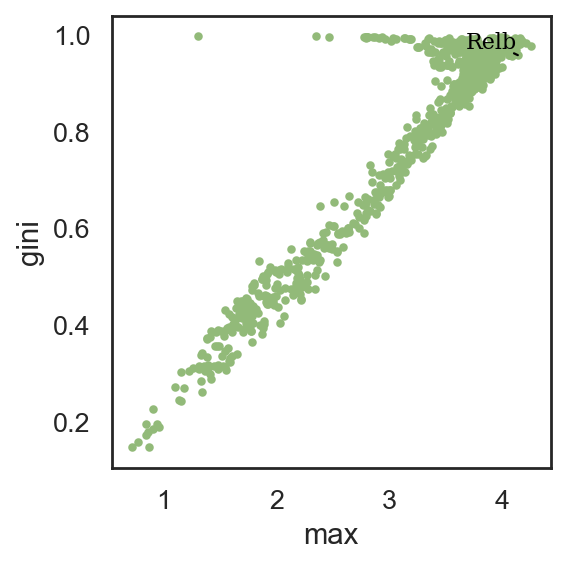

In [9]:
si.pl.entity_metrics(adata_cmp_CM,x='max',y='gini',
                     show_texts=True,
                     texts=['Relb'],
                     show_cutoff=False,
                     show_contour=False,
                     c='#92ba79',
                     cutoff_x=3,
                     cutoff_y=0.7)

In [10]:
tf_name = "Relb"
midx = np.where(adata_cmp_CM.var.index.map(lambda s: tf_name.lower() in s.lower()))[0][0]
gidx = np.where(adata_cmp_CG.var.index.map(lambda s: tf_name.lower() in s.lower()))[0][0]

In [11]:
adata_C.obs['Relb_motif'] = adata_cmp_CM.layers['softmax'][:,midx]
adata_C.obs['Relb_gene'] = adata_cmp_CG.layers['softmax'][:,gidx]

In [12]:
palette = {"TAC-2":"#ff7f0e", "TAC-1":"grey", "IRS":"lightgrey", "Medulla":"black", "Hair Shaft-cuticle.cortex":"black", "Relb +":"red"}
palette2 = {"TAC-2":"#ff7f0e","TAC-2 Relb TF +":"#d62728",
            "TAC-1":"#F8D856", "IRS":"#ad494a", "Medulla":"#8c564b", "Hair Shaft-cuticle.cortex":"#c49c94", "Relb +":"red"}

In [14]:
motif_sm_score = adata_cmp_CM[:,'Relb'].layers['softmax'].toarray()[:,0]
gene_sm_score = adata_cmp_CG[:,"Relb"].layers['softmax'].toarray()[:,0]
motif_300_thres = np.sort(motif_sm_score)[-300]
gene_300_thres = np.sort(gene_sm_score)[-300]
selected_cells = adata_cmp_CM.obs.index[np.where((motif_sm_score >= motif_300_thres)&(gene_sm_score >= gene_300_thres))[0]]
selected = (motif_sm_score >= motif_300_thres)&(gene_sm_score >= gene_300_thres)
adata_C.obs['selected'] = selected

In [15]:
adata_C.obs['celltype2'] = adata_C.obs['celltype'].copy().astype(str)
adata_C.obs.loc[selected_cells, 'celltype2'] = 'Relb +'
adata_C.obs.celltype2 = adata_C.obs.celltype2.astype('category')
adata_cmp_CM.obs.loc[adata_C.obs.index, 'celltype2'] = adata_C.obs.celltype2

/tmp/ipykernel_15227/1369383244.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  adata_cmp_CM.obs.loc[adata_C.obs.index, 'celltype2'] = adata_C.obs.celltype2


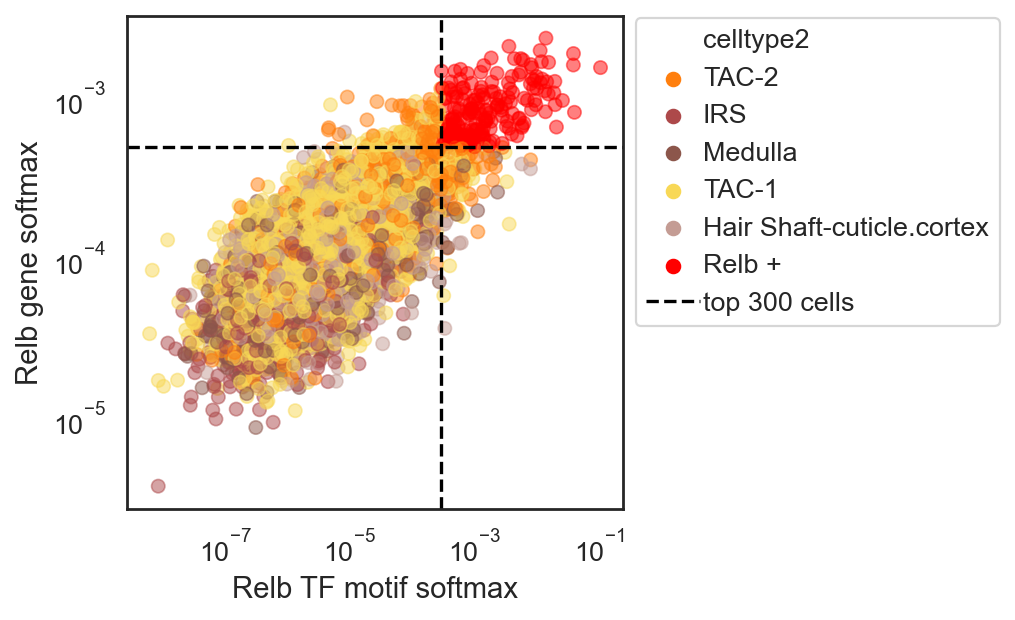

In [18]:
sns.scatterplot(x = motif_sm_score, y = gene_sm_score,
                hue=adata_cmp_CM.obs['celltype2'], palette=palette2, alpha=0.5, edgecolor=None, rasterized=True)
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Relb TF motif softmax")
plt.ylabel("Relb gene softmax")
plt.axvline(motif_300_thres, color='black', linestyle='--', label='top 300 cells')
plt.axhline(gene_300_thres, color='black', linestyle='--')
plt.legend(bbox_to_anchor=(1.02,1))
#plt.savefig("b.pdf", bbox_inches = 'tight')

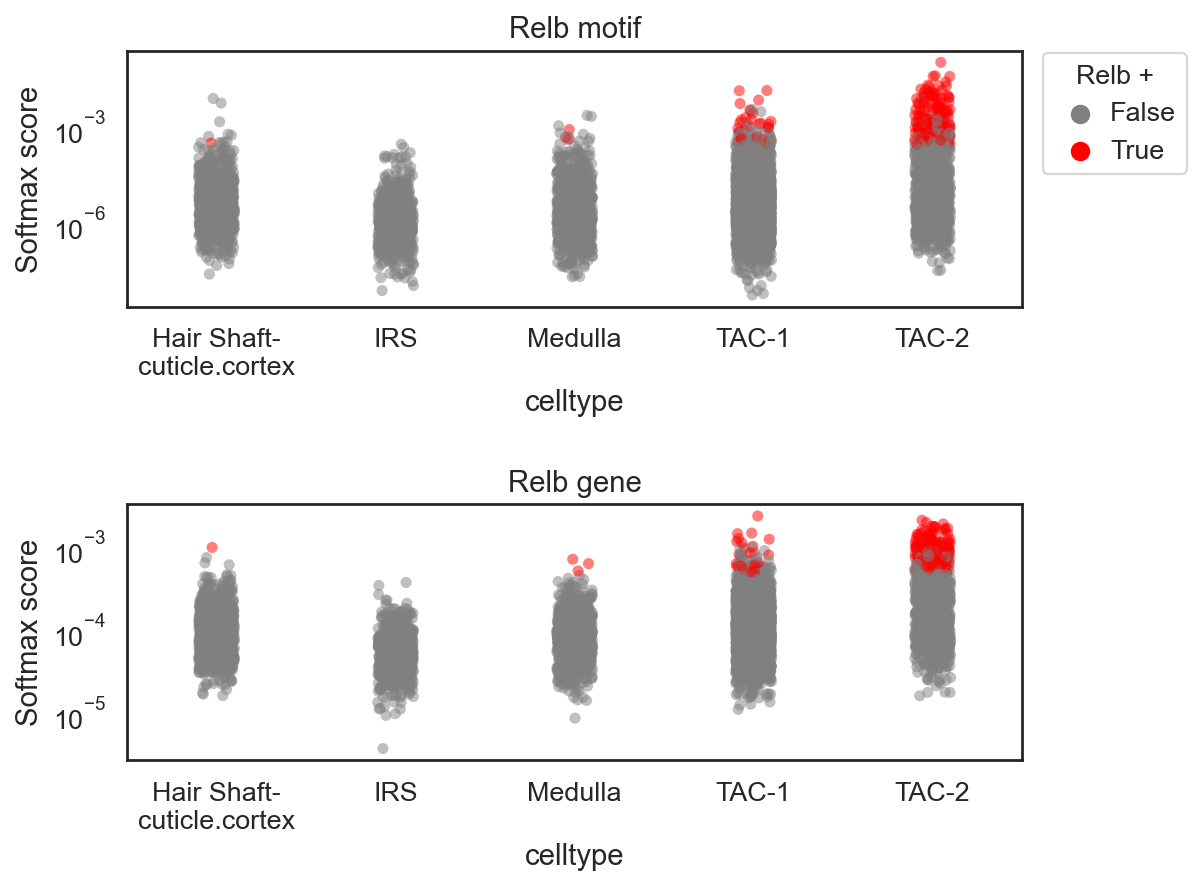

In [19]:
fig, ax = plt.subplots(2,1, figsize=(8,6))

sns.stripplot(data=adata_C.obs[['celltype', 'Relb_motif', 'selected']], x = 'celltype', y = 'Relb_motif', hue='selected', palette={True:'red',False:'grey'}, ax = ax[0], alpha = 0.5, rasterized=True)
ax[0].set_yscale('log')
sns.stripplot(data=adata_C.obs[['celltype', 'Relb_gene', 'selected']], x = 'celltype', y = 'Relb_gene', hue='selected', palette={True:'red',False:'grey'}, ax = ax[1], alpha = 0.5, rasterized=True)
ax[1].set_yscale('log')
ax[0].legend(title='Relb +', bbox_to_anchor=(1.02,1))
ax[1].get_legend().remove()
plt.setp(ax, ylabel='Softmax score')
ax[0].set_xticklabels(["Hair Shaft-\ncuticle.cortex", "IRS", "Medulla", "TAC-1", "TAC-2"])
ax[1].set_xticklabels(["Hair Shaft-\ncuticle.cortex", "IRS", "Medulla", "TAC-1", "TAC-2"])
ax[0].set_title("Relb motif")
ax[1].set_title("Relb gene")
plt.tight_layout()
#plt.savefig("d.pdf", bbox_inches = 'tight')

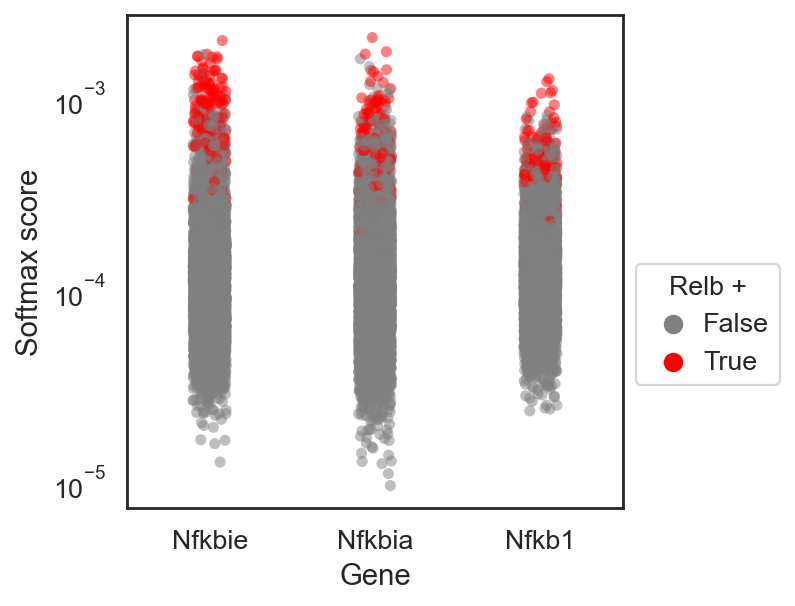

In [20]:
plot_data = pd.DataFrame(adata_cmp_CG[:,["Nfkbie", "Nfkbia", "Nfkb1"]].layers['softmax'].toarray(), columns=["Nfkbie", "Nfkbia", "Nfkb1"])
plot_data['selected'] = selected

sns.stripplot(data = plot_data.melt(id_vars=["selected"]), 
              x='variable', y='value',
                hue = 'selected', alpha=0.5, s =5, edgecolor=None, palette={True:'red',False:'grey'}, hue_order=[False, True], rasterized=True)

plt.yscale('log')
plt.xlabel("Gene")
plt.ylabel("Softmax score")
plt.legend(title='Relb +', bbox_to_anchor=(1.02, 0.5))
#plt.savefig("f.pdf")

In [21]:
adata_C.obs['Relb_gene_raw'] = adata_CG[adata_C.obs.index, "Relb"].X.toarray()
adata_C.obs['Nfkbie_gene_raw'] = adata_CG[adata_C.obs.index, "Nfkbie"].X.toarray()
adata_C.obs['Nfkbia_gene_raw'] = adata_CG[adata_C.obs.index, "Nfkbia"].X.toarray()
adata_C.obs['Nfkb1_gene_raw'] = adata_CG[adata_C.obs.index, "Nfkb1"].X.toarray()
adata_C.obs['Rela'] = adata_CG[adata_C.obs.index, "Rela"].X.toarray()

In [22]:
adata_C.obs['Relb_gene_softmax'] = adata_cmp_CG[adata_C.obs.index, "Relb"].layers['softmax'].toarray()
adata_C.obs['Nfkbie_gene_softmax'] = adata_cmp_CG[adata_C.obs.index, "Nfkbie"].layers['softmax'].toarray()
adata_C.obs['Nfkbia_gene_softmax'] = adata_cmp_CG[adata_C.obs.index, "Nfkbia"].layers['softmax'].toarray()
adata_C.obs['Nfkb1_gene_softmax'] = adata_cmp_CG[adata_C.obs.index, "Nfkb1"].layers['softmax'].toarray()
adata_C.obs['Rela_softmax'] = adata_cmp_CG[adata_C.obs.index, "Rela"].layers['softmax'].toarray()

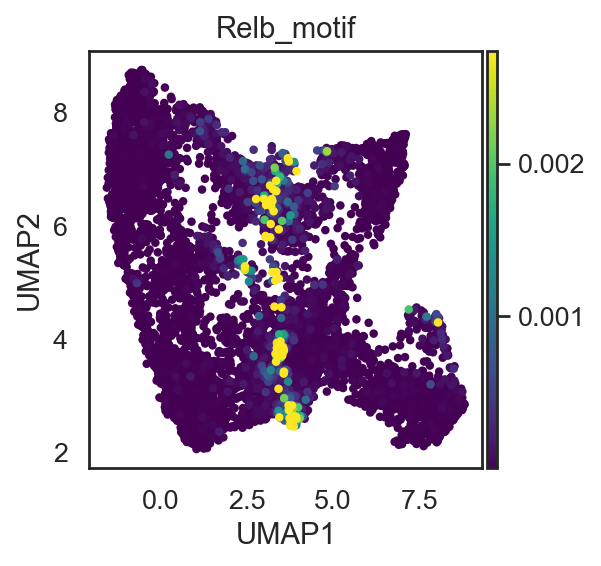

In [23]:
si.pl.umap(adata_C, color=['Relb_motif'], vmax=np.quantile(adata_C.obs['Relb_motif'], 0.99), rasterized=True)
#plt.savefig("a1.pdf")

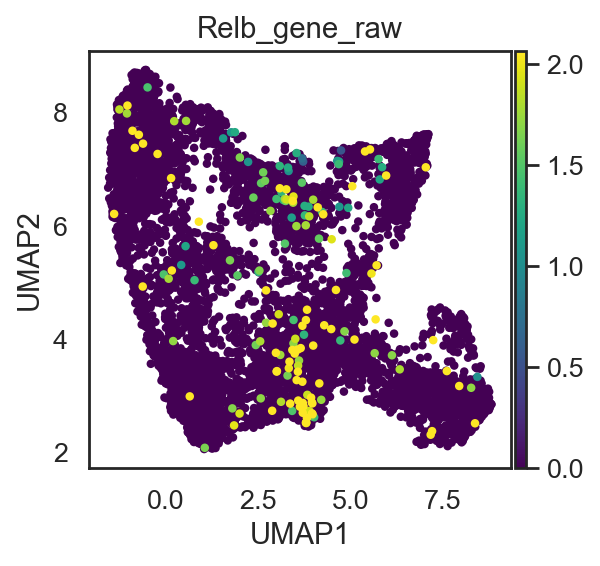

In [24]:
si.pl.umap(adata_C, color=['Relb_gene_raw'], vmax=np.quantile(adata_C.obs['Relb_gene_raw'], 0.99), rasterized=True)
#plt.savefig("a2.pdf")  

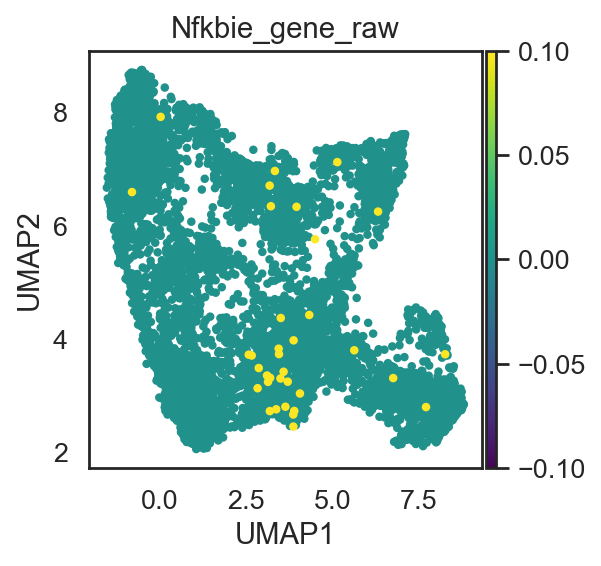

In [25]:
si.pl.umap(adata_C, color=['Nfkbie_gene_raw'], vmax=np.quantile(adata_C.obs['Nfkbie_gene_raw'], 0.99), rasterized=True)
#plt.savefig("e1.pdf", bbox_inches = 'tight')

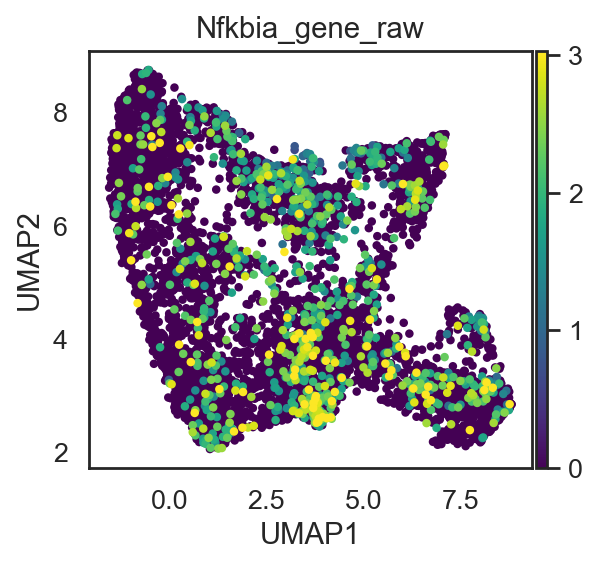

In [26]:
si.pl.umap(adata_C, color=['Nfkbia_gene_raw'], vmax=np.quantile(adata_C.obs['Nfkbia_gene_raw'], 0.99), rasterized=True)
#plt.savefig("e2.pdf", bbox_inches = 'tight')

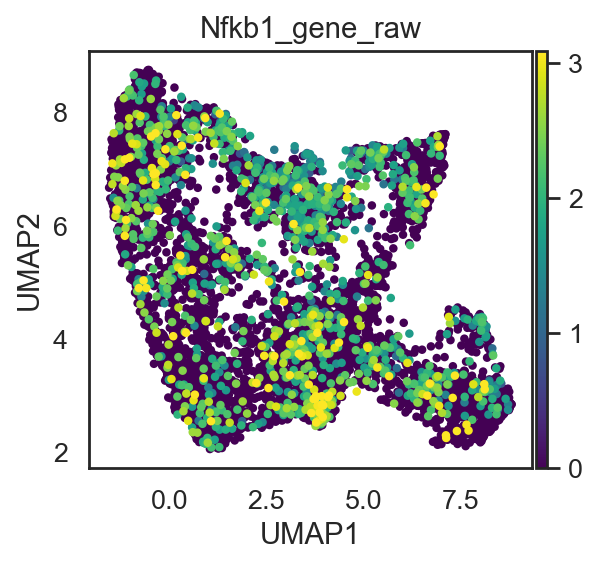

In [27]:
si.pl.umap(adata_C, color=['Nfkb1_gene_raw'], vmax=np.quantile(adata_C.obs['Nfkb1_gene_raw'], 0.99), rasterized=True)
#plt.savefig("e3.pdf", bbox_inches = 'tight')

In [28]:
adata_C.uns['color']['celltype2_color'] = adata_C.uns['color']['celltype_color'].copy()
adata_C.uns['color']['celltype2_color']['Relb +'] = "#d62728"
adata_C.uns['color']['celltype2_color']['TAC-2'] = "#ff9896"

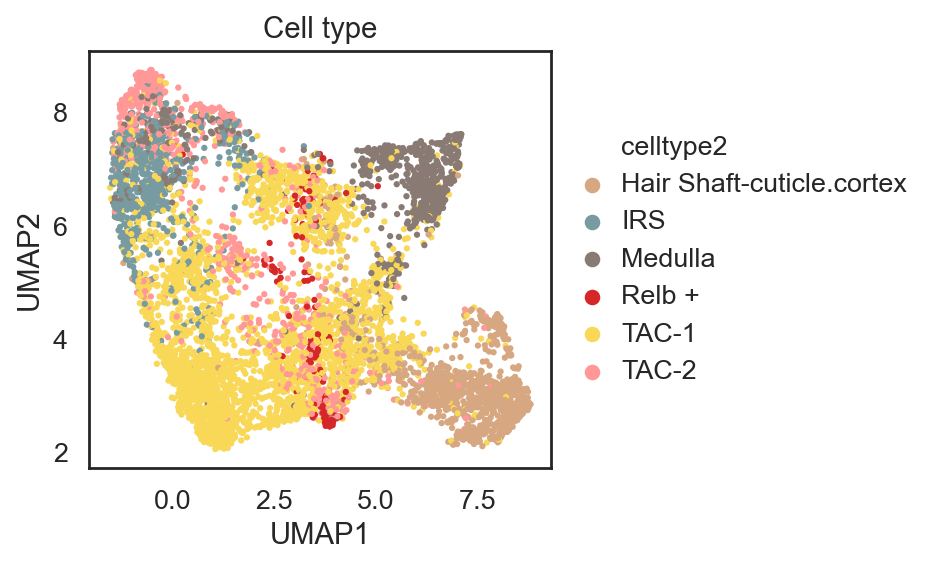

In [29]:
si.pl.umap(adata_C, color=['celltype2'], fig_size=(6,4), drawing_order="random", rasterized=True)
plt.title("Cell type")
plt.savefig("c.pdf", bbox_inches = 'tight')